In [7]:
import stim
import numpy as np
import itertools
from copy import copy
from copy import deepcopy
from random import random
import sys
import matplotlib.pyplot as plt

H 0
DEPOLARIZE1(0.8) 1 2 3
CX 0 1
DEPOLARIZE1(0.8) 2 3
Y 0 2
DEPOLARIZE1(0.8) 1 3
CX 0 1 2 3
SWAP 1 2
DEPOLARIZE1(0.8) 0 3
H 2
DEPOLARIZE1(0.8) 0 1 3
CX 2 1 2 3
DEPOLARIZE1(0.8) 0
MR 0 1


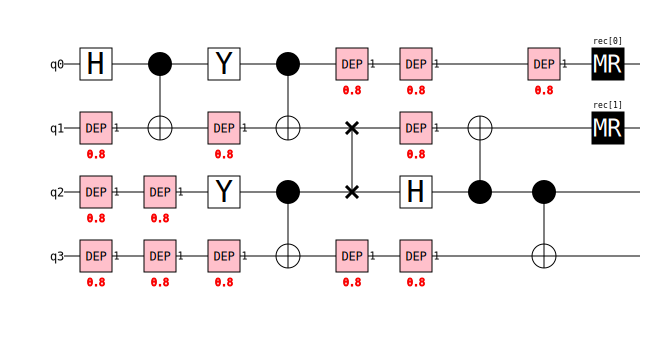

In [8]:
"Parse a stim circuit and add single qubit depolarizing errors for each no-op in the circuit"
def add_identity_error(circuit, prob):
    new_circuit = stim.Circuit()
    # Get the number of qubits in the circuit
    num_qubits = circuit.num_qubits
    for op in circuit:
        new_circuit.append(op)
        qubits = set(range(num_qubits))
        active_qubits = set([x.value for x in op.targets_copy()])
        noop_qubits = list(qubits.difference(active_qubits))
        if len(noop_qubits) > 0: new_circuit.append("DEPOLARIZE1", noop_qubits, prob)
    return new_circuit

test = stim.Circuit()
test.append("H", 0)
test.append("CNOT", [0,1])
test.append("Y", [0,2])
test.append("CNOT", [0,1,2,3])
test.append("SWAP",[1,2])
test.append("H", [2])
test.append("CNOT",[2,1,2,3])
test_with_error = add_identity_error(test, 0.8)
test_with_error.append("MR", [0,1])
print(test_with_error)
test_with_error.diagram(type="timeline-svg")

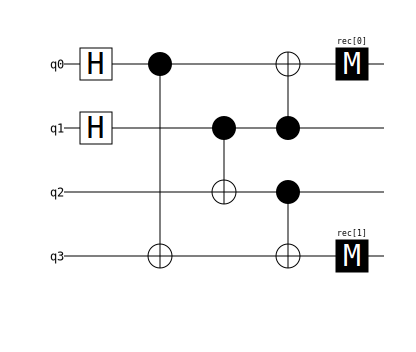

In [23]:
test = stim.Circuit()
test.append("H", [0,1])
test.append("CNOT", [0,3,1,2])
test.append("CNOT", [1,0,2,3])
test.append("M", [0,3])
test.diagram(type="timeline-svg")

In [26]:
simulator = stim.TableauSimulator()
simulator.do(test)
print(simulator.current_inverse_tableau()**-1)
simulator.canonical_stabilizers()

+-xz-xz-xz-xz-
| +- ++ ++ ++
| XZ __ __ _Z
| __ ZX _Z _Z
| __ _X XZ _Z
| X_ __ X_ XZ


[stim.PauliString("-Z___"),
 stim.PauliString("+_XX_"),
 stim.PauliString("+_ZZ_"),
 stim.PauliString("-___Z")]

In [28]:
reduced_simulator = stim.TableauSimulator()
p1 = stim.PauliString("+XX")
p2 = stim.PauliString("+ZZ")
reduced_simulator.set_state_from_stabilizers([p1,p2])
print(reduced_simulator.current_inverse_tableau())
print(reduced_simulator.canonical_stabilizers())
reduced_simulator.state_vector()

+-xz-xz-
| ++ ++
| ZX _X
| X_ XZ
[stim.PauliString("+XX"), stim.PauliString("+ZZ")]


array([0.70710677+0.j, 0.        +0.j, 0.        +0.j, 0.70710677+0.j],
      dtype=complex64)

In [57]:
"""
Extracts the statevector corresponding to the output Bell state

This function runs under the assumption that the Bell pair is located at the last 2 qubits of the circuit.
"""
def extract_statevector(simulator):
    q = simulator.num_qubits
    stabs = simulator.canonical_stabilizers()
    bell_stabs = [] #stabilizers for reduced state (presumably a bell pair)
    for s in [stabs[-2], stabs[-1]]:
        stab_string = s.__str__()
        phase = stab_string[0] 
        qubits = stab_string[q-1] + stab_string[q]
        bell_stabs.append(stim.PauliString(phase+qubits))
    bell_simulator = stim.TableauSimulator()
    bell_simulator.set_state_from_stabilizers(bell_stabs)
    return bell_simulator.state_vector()